In [193]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopack import geopack
import pyspedas
import sys
import pandas as pd
import seaborn as sns

sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
from esn_dts_openloop import ESN, Tikhonov


Open the raw REPPU data

In [194]:
#REPPU otuputs
path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Data/pbig5min.dat'

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

nsteps = 45792 #159 days * 24 hours * 60 minutes / 5 minutes

#30 = latitute = 53.10° to 89.73° with 30 intervals worth
#80 = longitude = 0° to 360° with 80 intervals worth
reppu_reshaped_data = reppu_data.reshape(nsteps, 30*80)
reppu_reshaped_data.shape

(45792, 2400)

28-Mar-24 20:12:33: /var/folders/n2/t9qn3_vj3nd6jb505jq_l8dw0000gn/T/ipykernel_46616/1192835326.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['N', '', 'W', '', 'S', '', 'E', ''])



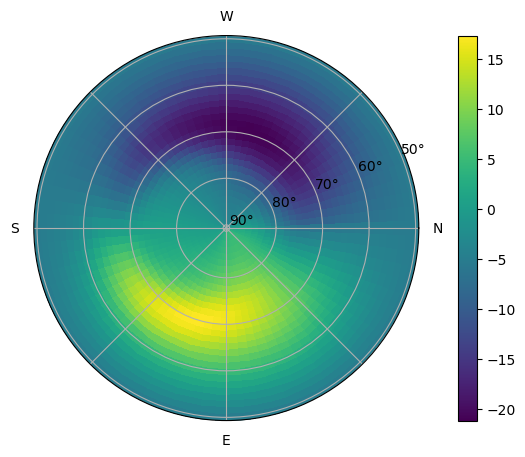

In [269]:
# Calculate the number of time steps per day
time_steps_per_day = nsteps // 159  # 12 (5 min intervals) * 24 hours per day

# Reshape the data to split each day into a separate axis
reppu_reshaped_data = np.reshape(reppu_data, (159, time_steps_per_day, 2400))

# Take the mean across each day (axis 1)
mean_per_day = np.mean(reppu_reshaped_data, axis=1)
lat_lon_reshape = mean_per_day.reshape(159, 30, 80)
lat_lon_reshape

#plt.imshow(lat_lon_reshape[10, :, :])

fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': 'polar'})
r = np.linspace(0, 1, 30)
theta = np.linspace(0, 2*np.pi, 80)
z = lat_lon_reshape[100, :, :]
grid = ax.pcolormesh(theta, r, z*1e-3, cmap='viridis')
ax.set_xticklabels(['N', '', 'W', '', 'S', '', 'E', ''])
ax.set_rticks([0,0.25, 0.5, 0.75,1])
ax.set_yticklabels(['90°','80°', '70°', '60°','50°'])
plt.colorbar(grid)


Select number of components

In [3]:
n_components = 10
pca = PCA(n_components=n_components)
pca.fit(reppu_reshaped_data)

PCA(n_components=10)

Visualise PCA components and determine ideal number

In [4]:
def plot_PCA_var(data):

    ''' This function plots the cumulative explained variance of the PCA components
    It is used to determine how many components are needed to explain the variance of the data
    A value of 1 means that all the variance is explained by the components'''

    explained_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(4,3))
    plt.plot(np.cumsum(explained_variance))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.grid()

#plot_PCA_var(reppu_reshaped_data)

def plot_PCA(data):

    '''This function plots PCA components of the data. Although PCA is dimensionaless
    #it is useful to plot the components to see what the data looks like in the new basis'''
    
    plt.figure(figsize=(15, 5))
    for i in range(n_components):
        plt.subplot(3,5, i+1)
        plt.imshow(pca.components_[i].reshape(30, 80), cmap='viridis')
        plt.title(f'PCA {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

#plot_PCA(reppu_reshaped_data)

Transform the data and the inversions for it

In [86]:
reppu_pca = pca.transform(reppu_reshaped_data) #transform the data to the new basis

mean_reppu_data = np.mean(reppu_reshaped_data, axis=0) #mean kV value across all lats and lons for 1 time step
pca_comp_data = pca.components_ #principal components of the data
inverse_pca = pca.inverse_transform(reppu_pca) #transform the data back to the original basis (with PCA)
inverse_pca_manual = np.dot(reppu_pca,pca_comp_data) + mean_reppu_data #reconstruct the data using the principal components (manual)

Load OMNI data and prep for ML

In [87]:
def read_sw_data(file_name):
    data = {'yy': [], 'mm': [], 'dd': [], 'hh': [], 'by': [], 'bz': [], 'v': [], 'n': []}
    
    with open(file_name, 'r') as f:
        for line in f:
            # Split the line by whitespace
            parts = line.split()
            if len(parts) == 8:  # Ensure all fields are present
                # Extract values and append to corresponding list
                data['yy'].append(float(parts[0]))
                data['mm'].append(float(parts[1]))
                data['dd'].append(float(parts[2]))
                data['hh'].append(float(parts[3]))
                data['by'].append(float(parts[4]))
                data['bz'].append(float(parts[5]))
                data['v'].append(float(parts[6]))
                data['n'].append(float(parts[7]))

    # Convert dictionary to DataFrame
    df = pd.DataFrame(data)
    return df

file_name = 'swall3_5min.txt'
sw_df = read_sw_data(file_name)


def calculate_ps(row):
    t0 = datetime.datetime(1970, 1, 1)
    t1 = datetime.datetime(int(row['yy']), int(row['mm']), int(row['dd']), int(row['hh']), int((row['hh'] % 1) * 60), 0)
    ut = (t1 - t0).total_seconds()
    ps = geopack.recalc(ut) # Calculate dipole tilt angle
    return ps

sw_df['tilt_angle'] = sw_df.apply(calculate_ps, axis=1)

def combine_to_datetime(row):
    return datetime.datetime(int(row['yy']), int(row['mm']), int(row['dd']), int(row['hh']))

sw_df['date'] = sw_df.apply(combine_to_datetime, axis=1)
sw_df['doy'] = sw_df['date'].dt.dayofyear
sw_df = sw_df[['date','doy','tilt_angle', 'by', 'bz', 'v', 'n']]
sw_df

,date,doy,tilt_angle,by,bz,v,n
0,2021-05-11 00:00:00,131,0.256817,1.14,0.484,0.023041,0.048442
1,2021-05-11 00:00:00,131,0.252889,1.12,1.560,0.018121,-0.018997
2,2021-05-11 00:00:00,131,0.249647,0.88,0.136,0.017602,-0.012334
3,2021-05-11 00:00:00,131,0.247075,0.34,-0.306,0.014646,-0.042393
4,2021-05-11 00:00:00,131,0.243255,-0.68,-0.674,0.017069,-0.037441
...,...,...,...,...,...,...,...
45787,2022-07-31 23:00:00,212,0.283323,2.32,3.520,0.184475,0.044069
45788,2022-07-31 23:00:00,212,0.279884,-0.46,3.418,0.181397,0.017200
45789,2022-07-31 23:00:00,212,0.276464,-5.38,4.378,0.175126,-0.024844
45790,2022-07-31 23:00:00,212,0.273064,-5.80,3.816,0.178249,-0.026687


<Figure size 1000x500 with 0 Axes>

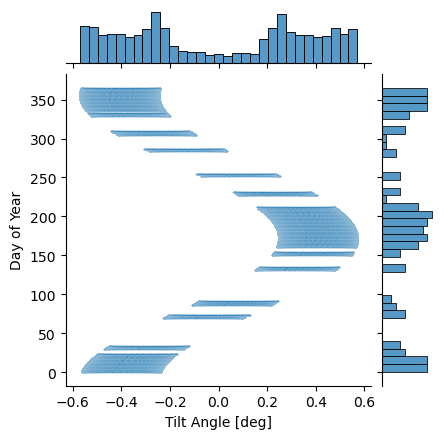

In [7]:
plt.figure(figsize=(10, 5))
sns.jointplot(data=sw_df, x='tilt_angle', y='doy', height=4.5, s=1)
plt.xlabel('Tilt Angle [deg]')
plt.ylabel('Day of Year')
plt.savefig('/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/plots/REPPU/potential_tilt_doy.png', dpi=300)

DO NO EDIT BELOW. ORIGINAL

In [88]:
meanp=np.load('meanp.npy')
imgpcap=np.load('imgp.npy')
datpcap=np.load('pcap.npy')

In [17]:
flearn=1e-6 #for pot and fac
data_d = datpcap*flearn #output data

def read_sw_data(file_name):
    dataa = np.empty(0)
    datab = np.empty(0)
    datac = np.empty(0)
    datad = np.empty(0)
    datae = np.empty(0)
    dataf = np.empty(0)
    datag = np.empty(0)
    datah = np.empty(0)

    with open(file_name, 'r') as f:
        lines = f.readlines()
        for line in lines:
            tmp = line.split()
            dataa = np.hstack((dataa, float(tmp[0])))  # yy
            datab = np.hstack((datab, float(tmp[1])))  # mm
            datac = np.hstack((datac, float(tmp[2])))  # dd
            datad = np.hstack((datad, float(tmp[3])))  # hh
            datae = np.hstack((datae, float(tmp[4])))  # by
            dataf = np.hstack((dataf, float(tmp[5])))  # bz
            datag = np.hstack((datag, float(tmp[6])))  # log10v-2.5
            datah = np.hstack((datah, float(tmp[7])))  # log10n-1.0

    return dataa,datab,datac,datad,datae,dataf,datag,datah

yy,mm,dd,hh,sw1,sw2,sw3,sw4 = read_sw_data(file_name='swall3_5min.txt') #y,m,d,h, by,bz,v,n

t0 = datetime.datetime(1970,1,1)
psarr=np.zeros(nsteps) # dipole tilt angle

for ii in range(0,nsteps):
     mn=60.0*(hh[ii]-int(hh[ii]))
     t1 = datetime.datetime(int(yy[ii]),int(mm[ii]),int(dd[ii]),int(hh[ii]),int(mn),0)
     ut = (t1-t0).total_seconds()
     ps = geopack.recalc(ut)
     psarr[ii]=ps

X = np.vstack((psarr,sw1,sw2,sw3,sw4))


In [94]:
class ESN_SR:
    def __init__(self, input_size, reservoir_size, output_size, density=0.1, input_scale=0.1, rho=0.99):
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size
        self.density = density
        self.input_scale = input_scale
        self.rho = rho

        # Initialize reservoir weights
        self.W_in = np.random.uniform(-input_scale, input_scale, size=(reservoir_size, input_size)).astype(float)
        self.W_res = np.random.choice([0, 1], size=(reservoir_size, reservoir_size), p=[1 - density, density]).astype(float)
        self.W_res *= np.random.uniform(-1, 1, size=(reservoir_size, reservoir_size))
        self.W_out = None
        #self.W_in = self.W_in.astype(float)
        #self.W_res = self.W_res.astype(float)

    def train(self, inputs, targets, reg_param):
        # Compute reservoir activations
        reservoir_states = np.zeros((len(inputs), self.reservoir_size))
        for t in range(len(inputs)):
            if t == 0:
                prev_state = np.zeros(self.reservoir_size)
            else:
                prev_state = reservoir_states[t - 1]

            reservoir_states[t] = np.tanh(self.W_in @ inputs[t] + self.W_res @ prev_state)

        # Apply ridge regression to compute output weights
        self.W_out = np.linalg.inv(reservoir_states.T @ reservoir_states + reg_param * np.eye(self.reservoir_size)) @ reservoir_states.T @ targets

    def predict(self, inputs):
        # Compute reservoir activations for prediction
        reservoir_states = np.zeros((len(inputs), self.reservoir_size))
        for t in range(len(inputs)):
            if t == 0:
                prev_state = np.zeros(self.reservoir_size)
            else:
                prev_state = reservoir_states[t - 1]

            reservoir_states[t] = np.tanh(self.W_in @ inputs[t] + self.W_res @ prev_state)

        # Predict output using output weights
        predictions = reservoir_states @ self.W_out
        return predictions


In [176]:
y = data_d

# Define the split index
split_index = 30816 #107 days * 24 hours* 12 (5min steps)

# Split the data into training and testing sets
X_train = X.T[:split_index]
X_test = X.T[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]

#print percentage of data used for training 
print(f'Training data: {len(X_train)/len(X.T)*100:.2f}%')

Training data: 67.30%


In [188]:
model = ESN_SR(input_size=X_train.shape[1], reservoir_size=100, output_size=y_train.shape[1], density=0.1, input_scale=0.1, rho=0.99)
model.train(X_train, y_train, reg_param=1e-2)
y_pred = model.predict(X_test)

In [189]:
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
mae = np.mean(np.abs(y_pred - y_test))
err_pct = np.mean(np.abs(y_pred - y_test) / y_test) * 100
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}', f'Error Pct: {err_pct:.2f}%')

RMSE: 0.11, MAE: 0.06 Error Pct: 72.79%


In [190]:
y_test_original.shape

(14976, 30, 80)

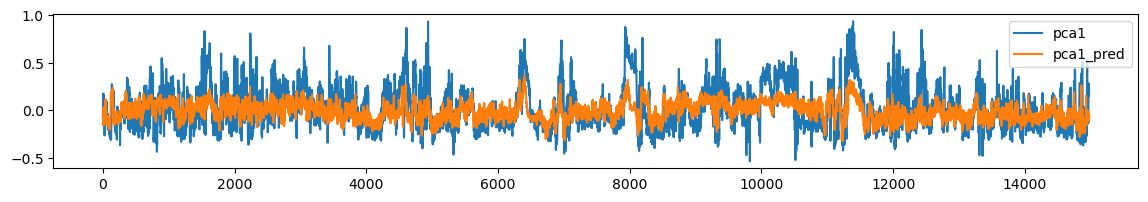

In [192]:
fig = plt.figure(figsize=(14, 14))
ax2 = fig.add_subplot(612)
ax2.plot(y_test[:,1], label='pca1')
ax2.plot(y_pred[:,1], label='pca1_pred')
ax2.legend()


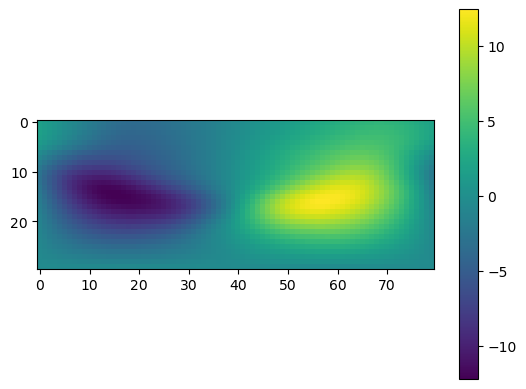

In [156]:
y_test_original = pca.inverse_transform(y_test)
y_test_original = y_test_original.reshape(-1, 30, 80)*1e-3
plt.imshow(y_test_original[0], cmap='viridis')
plt.colorbar()

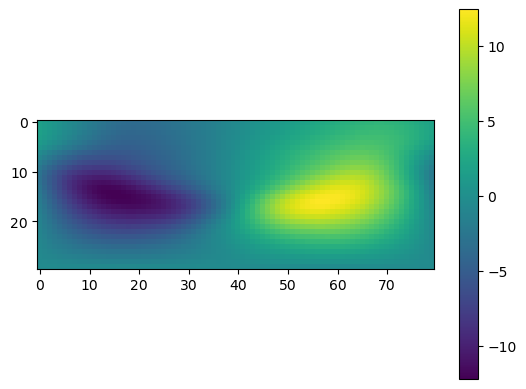

In [155]:
y_pred_original = pca.inverse_transform(y_pred)
y_pred_original = y_pred_original.reshape(-1, 30, 80)*1e-3
y_pred_original[1]
plt.imshow(y_pred_original[1], cmap='viridis')
plt.colorbar()


In [174]:
rmse = np.sqrt(np.mean((y_pred_original - y_test_original) ** 2))
mae = np.mean(np.abs(y_pred_original - y_test_original))
err_pct = np.mean(np.abs(y_pred_original - y_test_original) / y_test_original) * 100
print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}', f'Error Pct: {err_pct:.2f}%')

RMSE: 0.00, MAE: 0.00 Error Pct: -0.00%


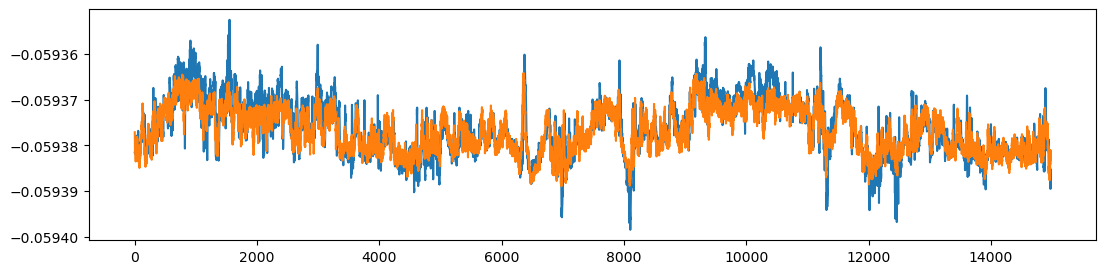

In [154]:
y_pred_mean = np.mean(y_pred_original, axis=(1,2))
y_test_mean = np.mean(y_test_original, axis=(1,2))

fig = plt.figure(figsize=(13, 3))
plt.plot(y_test_mean, label='test')
plt.plot(y_pred_mean, label='pred')


28-Mar-24 19:30:53: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


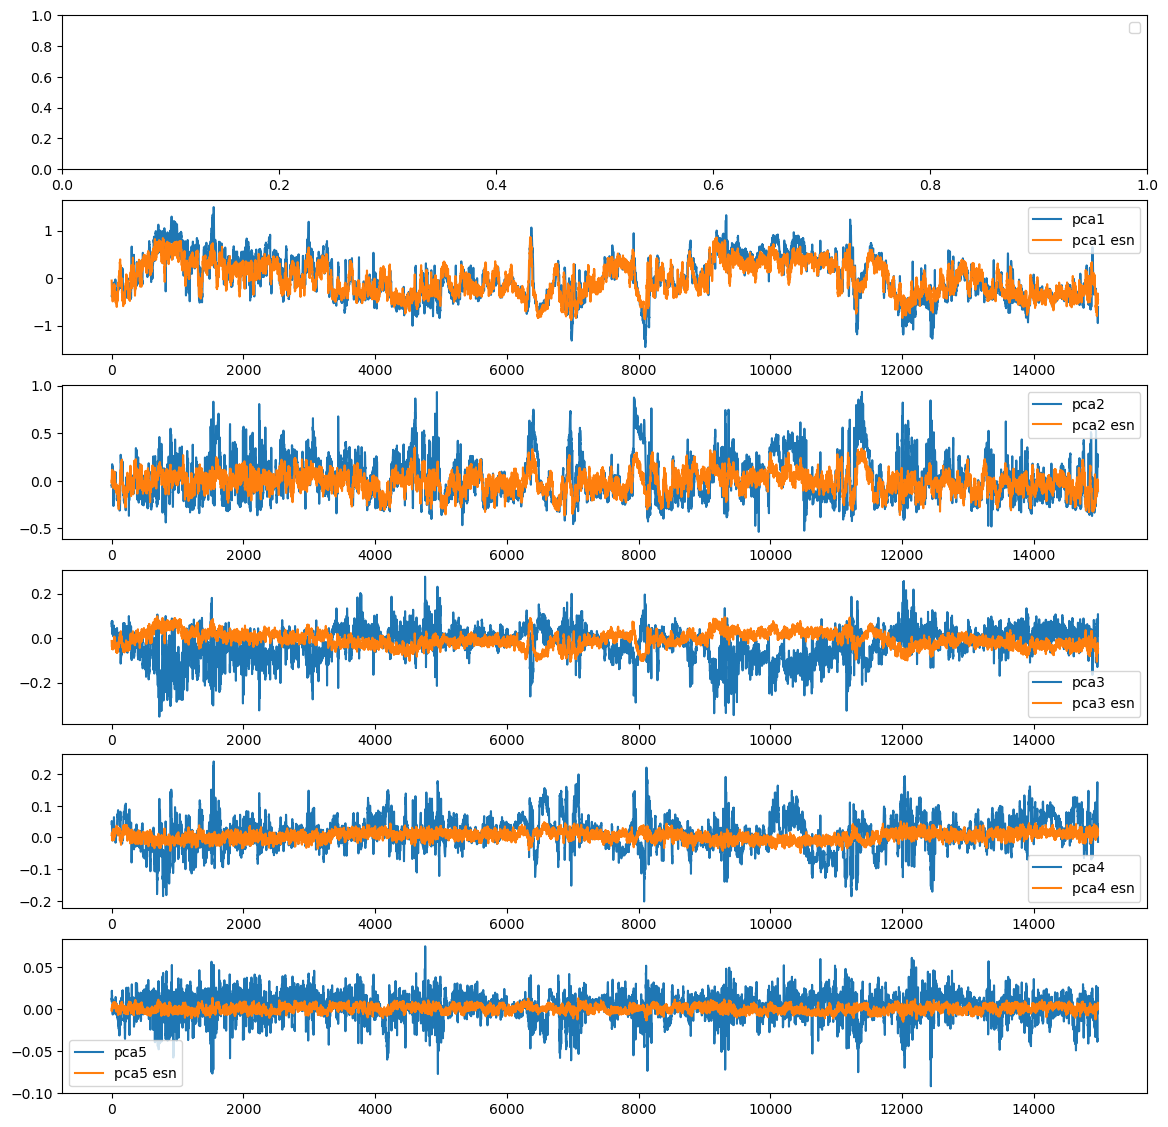

In [115]:
fig = plt.figure(figsize=(14, 14))
    
ax1 = fig.add_subplot(611)
#ax1.plot(data_u[:,0], label='tilt')
#ax1.plot(data_u[:,1]/10, label='By/10')
#ax1.plot(data_u[:,2]/10, label='Bz/10')
#ax1.plot(data_u[:,3], label='log10(Vsw)-2.5')
#ax1.plot(data_u[:,4], label='log10(Np)-1.0')
ax1.legend()

ax2 = fig.add_subplot(612)
ax2.plot(y_test[:,0], label='pca1')
ax2.plot(y_pred[:,0], label='pca1 esn')
ax2.legend()

ax3 = fig.add_subplot(613)
ax3.plot(y_test[:,1], label='pca2')
ax3.plot(y_pred[:,1], label='pca2 esn')
ax3.legend()

ax4 = fig.add_subplot(614)
ax4.plot(y_test[:,2], label='pca3')
ax4.plot(y_pred[:,2], label='pca3 esn')
ax4.legend()

ax5 = fig.add_subplot(615)
ax5.plot(y_test[:,3], label='pca4')
ax5.plot(y_pred[:,3], label='pca4 esn')
ax5.legend()

ax6 = fig.add_subplot(616)
ax6.plot(y_test[:,9], label='pca5')
ax6.plot(y_pred[:,9], label='pca5 esn')
ax6.legend()

plt.show()

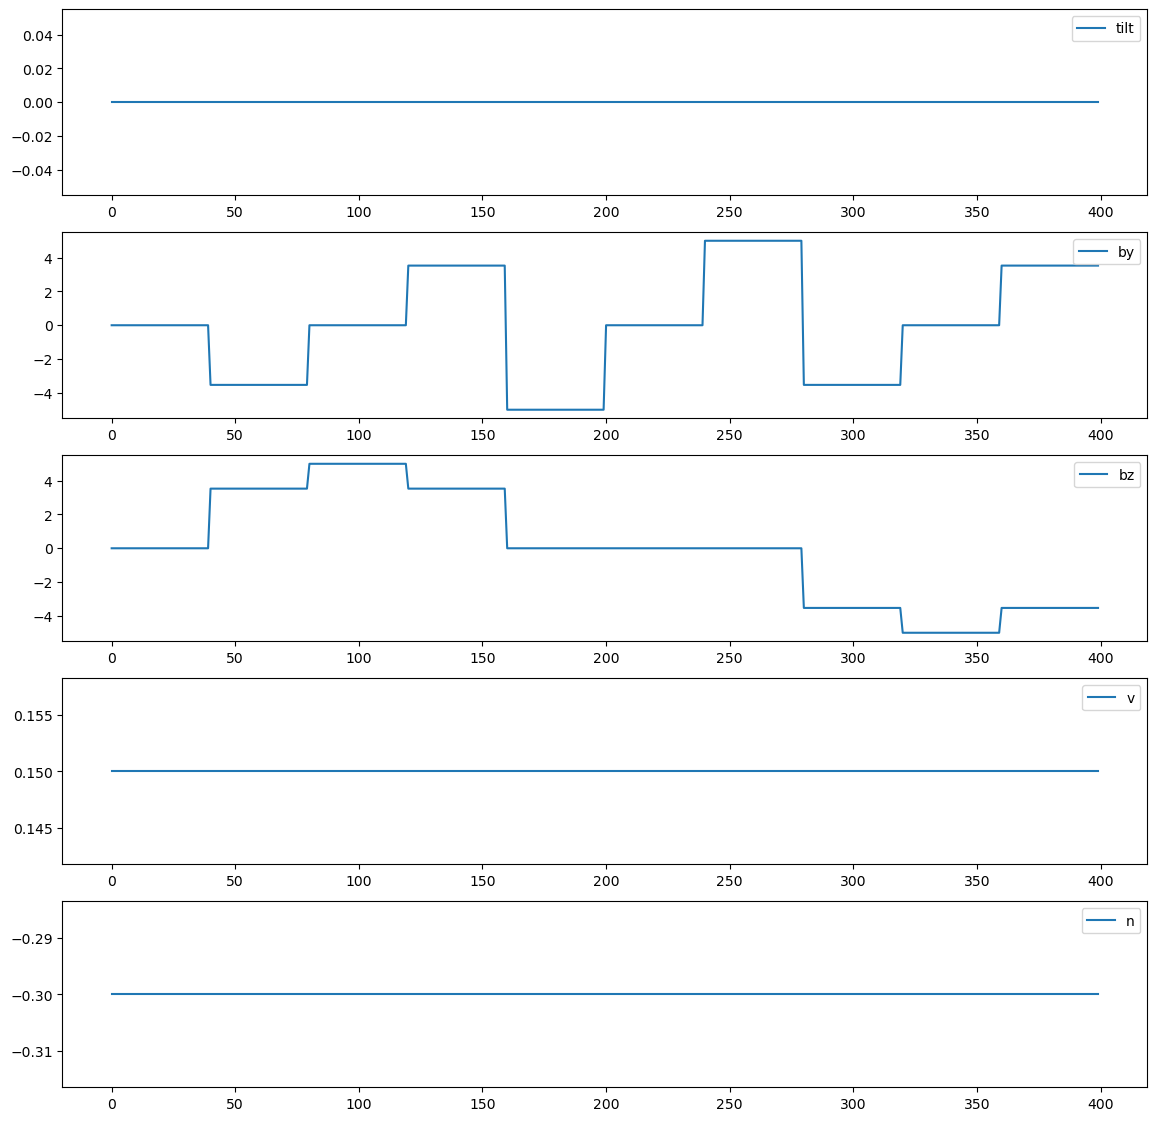

In [47]:
#synthetic solar wind

bz=np.zeros(40)
by=np.zeros(40)
for i in  range(0,9):
    if i == 0:
        by0=np.zeros(40)-3.53
        bz0=np.zeros(40)+3.53
    if i == 1:
        by0=np.zeros(40)
        bz0=np.zeros(40)+5.0
    if i == 2:
        by0=np.zeros(40)+3.53
        bz0=np.zeros(40)+3.53
    if i == 3:
        by0=np.zeros(40)-5.0
        bz0=np.zeros(40)+.0
    if i == 4:
        by0=np.zeros(40)
        bz0=np.zeros(40)
    if i == 5:
        by0=np.zeros(40)+5.0
        bz0=np.zeros(40)
    if i == 6:
        by0=np.zeros(40)-3.53
        bz0=np.zeros(40)-3.53
    if i == 7:
        by0=np.zeros(40)
        bz0=np.zeros(40)-5.0
    if i == 8:
        by0=np.zeros(40)+3.53
        bz0=np.zeros(40)-3.53

    by=np.append(by,by0)
    bz=np.append(bz,bz0)

tlt2=np.zeros(40*10)
byp2=by
bzp2=bz
#vvp2=np.zeros(40*10)+0.1 #400 km
vvp2=np.zeros(40*10)+0.15 #450 km
nnp2=np.zeros(40*10)-0.3 #5 /cc

fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(511)
ax1.plot(tlt2, label='tilt')
ax1.legend()

ax2 = fig.add_subplot(512)
ax2.plot(byp2, label='by')
ax2.legend()

ax3 = fig.add_subplot(513)
ax3.plot(bzp2, label='bz')
ax3.legend() 

ax4 = fig.add_subplot(514)
ax4.plot(vvp2, label='v')
ax4.legend()

ax5 = fig.add_subplot(515)
ax5.plot(nnp2, label='n')
ax5.legend()

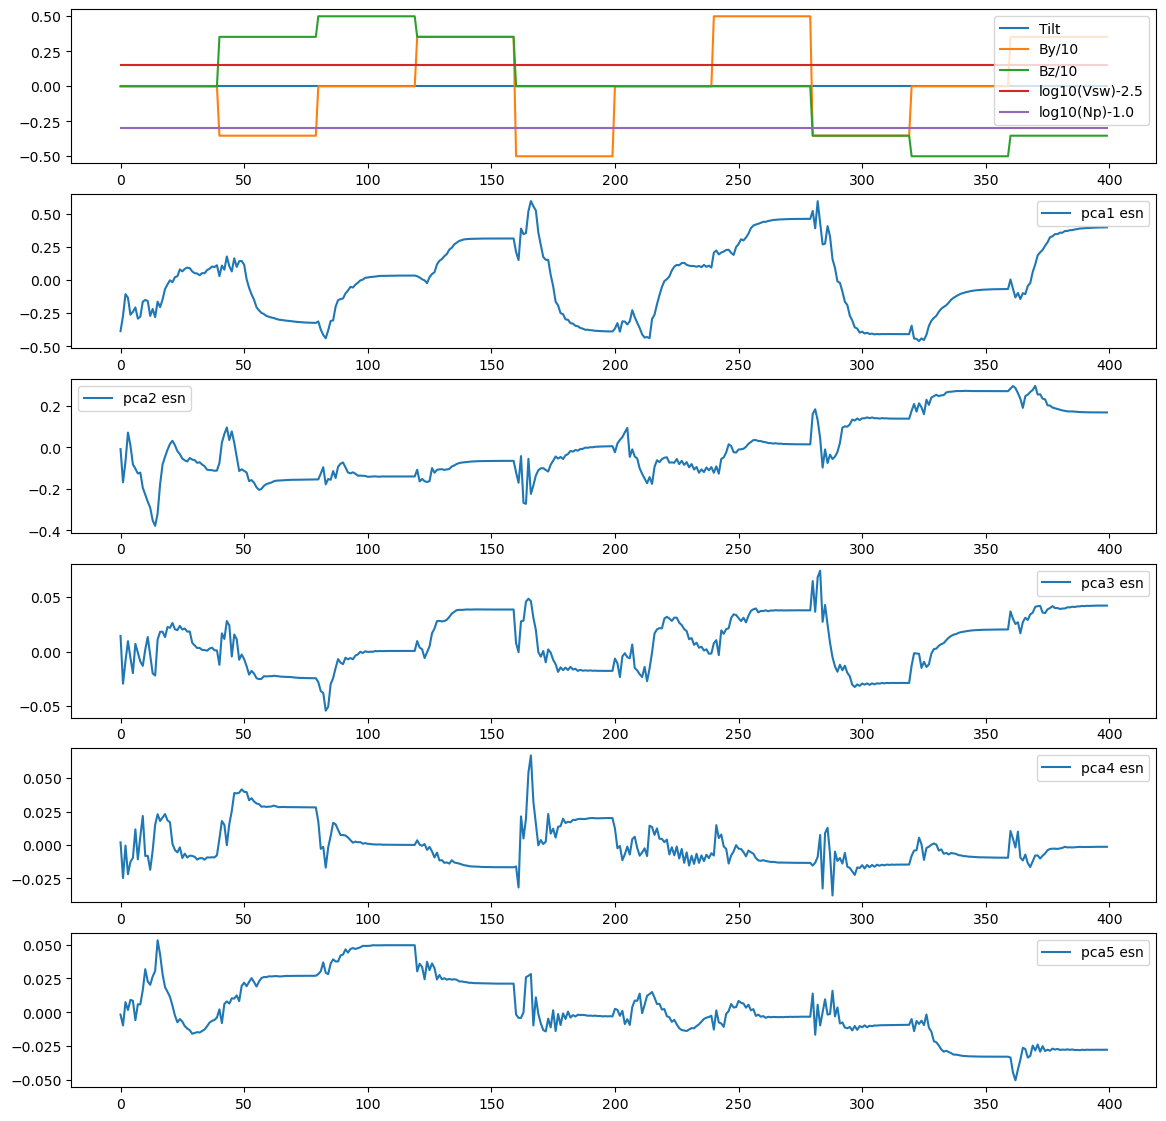

In [48]:
all10 = np.vstack((tlt2.T,byp2.T,bzp2.T,vvp2.T,nnp2.T))
data_s = all10.T

test_Y = modelp.predict(data_s)
pcap = test_Y/flearn

fig = plt.figure(figsize=(14, 14))
    
ax1 = fig.add_subplot(611)
ax1.plot(data_s[:,0], label='Tilt')
ax1.plot(data_s[:,1]/10, label='By/10')
ax1.plot(data_s[:,2]/10, label='Bz/10')
ax1.plot(data_s[:,3], label='log10(Vsw)-2.5')
ax1.plot(data_s[:,4], label='log10(Np)-1.0')
ax1.legend()

ax2 = fig.add_subplot(612)
ax2.plot(test_Y[:,0], label='pca1 esn')
ax2.legend()

ax3 = fig.add_subplot(613)
ax3.plot(test_Y[:,1], label='pca2 esn')
ax3.legend()

ax4 = fig.add_subplot(614)
ax4.plot(test_Y[:,2], label='pca3 esn')
ax4.legend()

ax5 = fig.add_subplot(615)
ax5.plot(test_Y[:,3], label='pca4 esn')
ax5.legend()

ax6 = fig.add_subplot(616)
ax6.plot(test_Y[:,4], label='pca5 esn')
ax6.legend()

plt.show()

In [53]:
p.shape

(400, 2400)

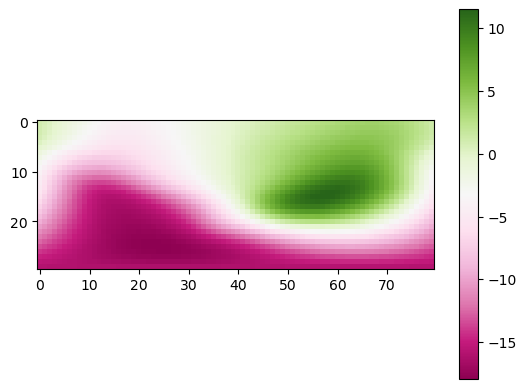

In [72]:
iii=3*40+40+30
p[iii].reshape(30,80)*1e-3

plt.imshow(p[iii].reshape(30,80)*1e-3, cmap='PiYG')
plt.colorbar()

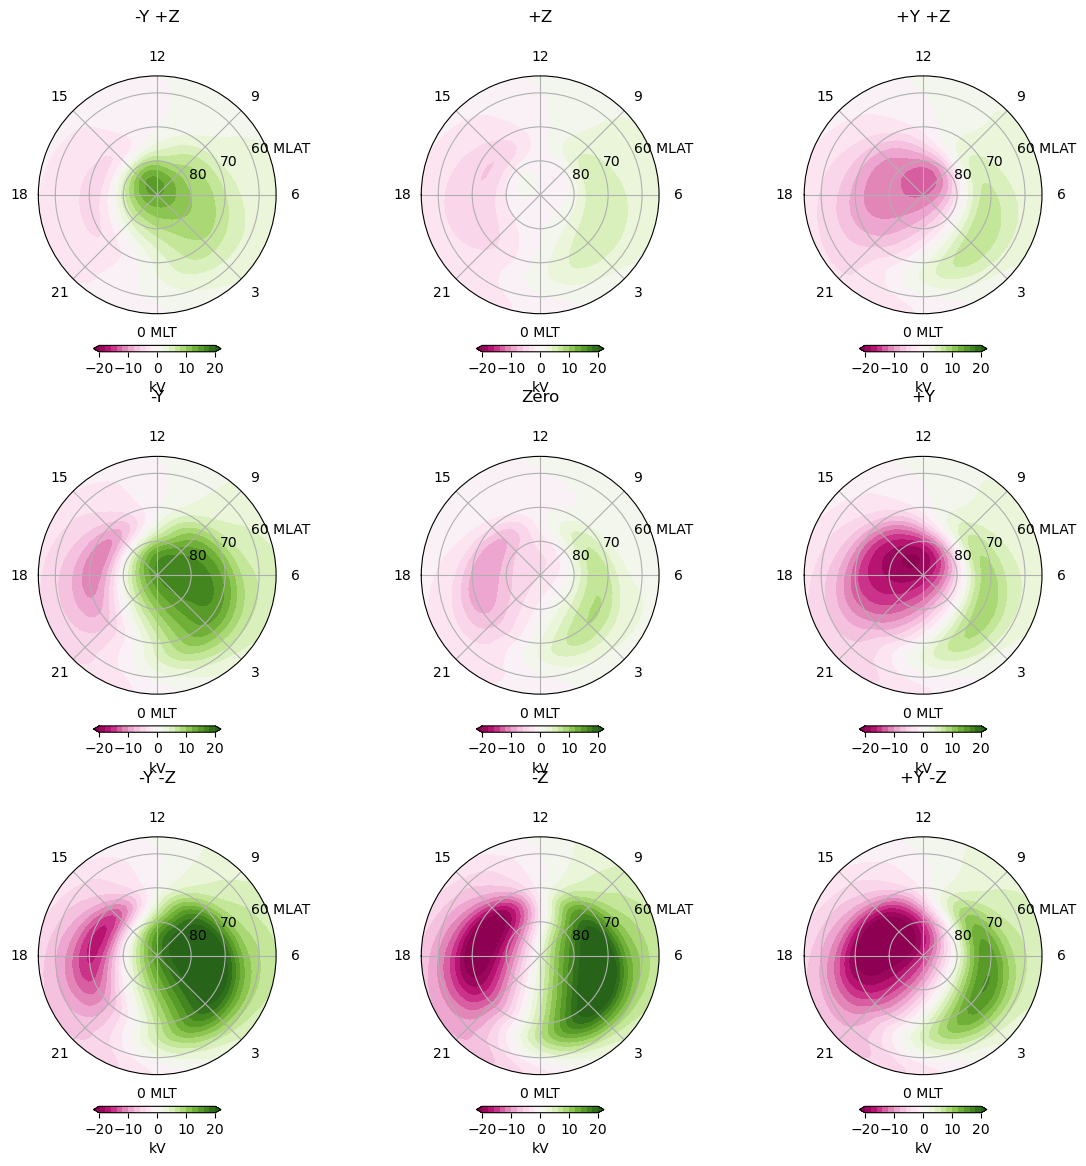

In [85]:
datpca=test_Y/flearn

p=np.dot(datpca,imgpcap)+meanp
#p = inverse_pca

fig = plt.figure(figsize=(14, 14))

theta=np.array([ 0.0, 11.25, 22.5, 33.75, 45.0, 56.25, 67.5, 78.75,
       90.0, 101.25, 112.5, 123.75, 135.0, 146.25, 157.5, 168.75, 
       180.0, 191.25, 202.5, 213.75, 225.0, 236.25, 247.5, 258.75, 
       270.0, 281.25, 292.5, 303.75, 315.0, 326.25, 337.5, 348.75, 360.0])


#normal grid lon
theta=np.array([  1.688 ,   6.188 ,  10.688 ,  15.188 ,  19.688 ,  24.188 ,  28.688 ,  33.188 ,  37.688 ,  42.188,
                46.688 ,  51.188 ,  55.688 ,  60.188 ,  64.688 ,  69.188 ,  73.688 ,  78.188 ,  82.688 ,  87.188,
                91.688 ,  96.188 , 100.688 , 105.188 , 109.688 , 114.188 , 118.688 , 123.188 , 127.688 , 132.188,
                136.688 , 141.188 , 145.687 , 150.188 , 154.688 , 159.188 , 163.688 , 168.187 , 172.687 , 177.187,
                181.687 , 186.187 , 190.687 , 195.187 , 199.687 , 204.187 , 208.687 , 213.187 , 217.687 , 222.187,
                226.687 , 231.187 , 235.687 , 240.187 , 244.687 , 249.187 , 253.687 , 258.187 , 262.687 , 267.187,
                271.687 , 276.187 , 280.687 , 285.187 , 289.687 , 294.187 , 298.687 , 303.187 , 307.687 , 312.187,
                316.687 , 321.187 , 325.687 , 330.187 , 334.687 , 339.187 , 343.687 , 348.187 , 352.687 , 357.187, 367.688])

theta = np.linspace(0,360,81)
theta=theta-90
theta=theta/360*np.pi*2

#normal grid lat north
r=np.array([53.109 ,  55.172 ,  57.234 ,  59.297 ,  61.359 ,  63.422 ,  65.484 ,  66.783 ,  67.826 ,  68.870,
            69.913 ,  70.957 ,  72.000 ,  73.044 ,  74.087 ,  75.130 ,  76.174 ,  77.217 ,  78.261 ,  79.304,
            80.348 ,  81.391 ,  82.435 ,  83.478 ,  84.522 ,  85.565 ,  86.609 ,  87.652 ,  88.696 ,  89.739])
r = np.linspace(53, 90,30)
r=90-r

tt, rr = np.meshgrid(theta,r) 

cmap0,unit0,f0 = 'PiYG','kV',1e-3 #kilo volt
interval_of_cf = np.linspace(-20, 20, 20+1)

iarr=np.arange(9)
ttlarr=["-Y +Z","+Z","+Y +Z","-Y","Zero","+Y","-Y -Z","-Z","+Y -Z",]

for i in iarr:

    iii=i*40+40+30
    
    ax=plt.subplot(3,3,i+1, polar=True)
    ax.set_title(ttlarr[i], pad=20)
    ax.set_ylim([0,35])
    ax.set_yticks([10,20,30])
    ax.set_yticklabels(["80","70","60 MLAT"])
    ax.set_xlim([-np.pi, np.pi])
    ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])

    z = p[iii].reshape(30,80)*f0 #Volt

    z2 = np.append(z, z[:, 0:1], axis=1)

#   ctf = plt.contourf(tt, rr, z2,interval_of_cf, cmap=cmap0, extend="both")
    ctf = plt.contourf(tt, rr, -z2,interval_of_cf, cmap=cmap0, extend="both")

    cbar=plt.colorbar(shrink=0.4, norm=ctf.norm, cmap=ctf.cmap, pad=0.1,ticks=interval_of_cf[::5], orientation='horizontal')
    cbar.set_label('kV')
    cbar.ax.yaxis.set_label_position('right')

plt.show()